# **Anime recommendation**

+ Alexander Sanchez Sanchez
+ Juan David Cruz Garcia
+ Juan Sebastian Perez Camacho
+ Kennet Santiago Sanchez Roldan

### El objetivo de este proyecto es construir un modelo de inteligencia artificial que sea capaz de recomendar animes a usuarios segun que animes hayan visto estos previamente y la calificacion dada.
### La informacion utilizada aqui es extraida de Kaggle desde el enlace: https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database

## Carga de librerias

In [1]:
import matplotlib.pyplot as plt    #Importamos pyplot de librería matplotlib. Lo vamos a utilizar para graficar.
import seaborn as sns              #Importamos la librería Seaborn. La vamos a utilizar para graficar.
import numpy as np                 #Importamos la librería numpy para manipular arreglos.
import pandas as pd
import os
import warnings

from pathlib import Path
from sklearn.model_selection import train_test_split #Útil para dividir los conjuntos de datos. 
from sklearn.preprocessing import MinMaxScaler       #Útil para escalar los atributos de entrada.

from copy import deepcopy                            #Permite hacer copias profundas. 

from sklearn.cluster import KMeans                   #Clase que implementa k-means.
from sklearn.metrics import silhouette_samples       #Útil para calcular el valor de la silueta de una observación. 
from sklearn.metrics import silhouette_score         #Útil para calcular el valor de la silueta de todas las observaciones.
from sklearn.metrics import calinski_harabasz_score  #Útil para calcular el valor del índice Calinski Harabasz (CH).
from sklearn.metrics import confusion_matrix         #Permite extraer la matriz de confusión.

#!pip install yellowbrick --upgrade                   #Instala y actualiza la librería yellowbrick (la versión por defecto en Google Colab está desactualizada).
from yellowbrick.cluster import KElbowVisualizer     #Permite obtener la gráfica del codo para tres métricas diferentes (distorsión, silueta, CH).
from yellowbrick.cluster import SilhouetteVisualizer 
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

## **Carga de datos**

In [2]:
#Anime.csv
path = Path(os.getcwd())
path = str(path.parent.absolute())
path = path+"/datos/anime.csv"
dfAnime = pd.read_csv(path,na_values='?')    

In [3]:
#rating.csv
path2 = Path(os.getcwd())
path2 = str(path2.parent.absolute())
path2 = path2+"/datos/rating.csv"
dfRating = pd.read_csv(path2,na_values='?')    

## **Tipos de dato adecuados**

**Definimos tipos para cada columna del dataframe que tenga como tipo "object"**

In [4]:
#anime.csv
dfAnime['name'] = dfAnime['name'].astype("string")
dfAnime['genre'] = dfAnime['genre'].astype("string")
dfAnime['type'] = dfAnime['type'].astype("string")
dfAnime['episodes']=pd.to_numeric(dfAnime.episodes, errors='coerce').dropna().astype(int)
dfAnime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  string 
 2   genre     12232 non-null  string 
 3   type      12269 non-null  string 
 4   episodes  11954 non-null  float64
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(2), int64(2), string(3)
memory usage: 672.5 KB


 **rating.csv ya tenia los tipos de datos adecuados**

## **Busqueda y eliminacion de valores nulos o duplicados**

**Vamos a buscar los valores nulos de los dataframes**

In [5]:
# anime.csv
print("La cantidad de datos nulos es:")
dfAnime.isna().sum().to_frame().T.style.set_properties(**{"background-color": "#2a9d8f","color":"white","border": "1.5px  solid black"})

La cantidad de datos nulos es:


,anime_id,name,genre,type,episodes,rating,members
0,0,0,62,25,340,230,0


In [6]:
# Rating.csv
print("La cantidad de datos nulos es:")
dfRating.isna().sum().to_frame().T.style.set_properties(**{"background-color": "#2a9d8f","color":"white","border": "1.5px  solid black"})

La cantidad de datos nulos es:


,user_id,anime_id,rating
0,0,0,0


+ **La cantidad de datos con valores nulos no es tan grande en comparacion al total asi que podemos borrarlos.**
+ **Eliminamos tambien los valores innecesarios. (En el caso de rating.csv, los rating con -1 son inutiles para nuestro problema puesto que simbolizan que el usuario no ha calificado el anime)**

In [7]:
dfAnime=dfAnime.dropna()
dfRating = dfRating[dfRating.rating != -1]

**Ahora buscamos el numero de datos duplicados y eliminamos en caso de que existan**

In [8]:
# Anime.csv
duplicados = dfAnime[dfAnime.duplicated()].shape[0]
print("Numero de datos duplicados ",duplicados)

Numero de datos duplicados  0


In [9]:
# Rating.csv
duplicados = dfRating[dfRating.duplicated()].shape[0]
print("Numero de datos duplicados ",duplicados)

Numero de datos duplicados  1


In [10]:
# Rating.csv
dfRating.drop_duplicates(keep='first',inplace=True)
duplicados = dfRating[dfRating.duplicated()].shape[0]
print("Numero de datos duplicados ",duplicados)

Numero de datos duplicados  0


## Ajustes para el dataframe anime.csv

+ **Convertimos "episodes" en una variable de numeros enteros para poder realizar adecuadamente el conteo**
+ **Convertimos "type" en una variable de tipo categoria para poder realizar analisis sobre este**

In [11]:
dfAnime['episodes'] = dfAnime['episodes'].astype(int)
dfAnime=dfAnime.replace({'Movie': '0', 'TV': '1','OVA':'2','ONA':'2','Special':'3','Music':'4'})
dfAnime['type'] = dfAnime['type'].astype("category")

**Se debe tener en cuenta que el dataframe cuenta con animes de todo tipo incluyendo peliculas, esto significa que muchos de los datos se veran alterados por esto, por ejemplo, la cantidad de episodios tiende a ser 1 si el anime es del tipo pelicula mientras que las series pueden llegar incluso a 100 episodios.**

**Por ello, es apropiado partir el dataframe en 2, uno para series de anime normales y otro para peliculas, ovas, etc.
Para evitar un problema demasiado complejo, solo trabajaremos con el dataframe de series. Eliminamos la columna "type" puesto que ya no sera de utilidad**

In [12]:
df_series = dfAnime.loc[dfAnime['type'] == '1']
df_series = df_series.drop('type',axis=1)

**El dataframe tiene todos los generos de un anime en una sola columna, para que esta informacion sea util, debemos clasificarla**

**Primero observemos que categorias son las mas populares**

In [13]:
genreCount = df_series[["genre"]]
genreCount["genre"] = genreCount["genre"].str.split(", | , | ,")
genreCount = genreCount.explode("genre")
genreCount["genre"] = genreCount["genre"].str.title()

print(f'Total unique genres are {len(genreCount["genre"].unique())}')
print(f'Occurances of unique genres :')
genreCount["genre"].value_counts().to_frame().T.style.set_properties(**{"background-color": "#2a9d8f","color":"white","border": "1.5px  solid black"})

Total unique genres are 41
Occurances of unique genres :


,Comedy,Action,Adventure,Sci-Fi,Fantasy,Shounen,Drama,Romance,Slice Of Life,School,Kids,Supernatural,Mecha,Magic,Shoujo,Historical,Ecchi,Sports,Seinen,Mystery,Super Power,Harem,Military,Space,Parody,Horror,Game,Music,Martial Arts,Psychological,Demons,Samurai,Police,Vampire,Cars,Thriller,Josei,Shoujo Ai,Shounen Ai,4,Dementia
genre,1769,1052,897,752,720,686,676,637,534,532,438,409,372,333,277,267,237,233,221,216,177,172,128,121,119,109,97,97,93,88,85,50,48,45,35,34,30,30,23,8,7


**Ahora, creemos una columna para cada uno de las 15 generos mas populares y eliminemos la columna genres**

In [14]:
def createNewColumn(colname):
    df_series[colname] = np.where(df_series.genre.str.contains(colname),1,0)
    df_series[colname] = df_series[colname].astype("category")

In [15]:
def containsGenre(dfInfo,word):  
    if str(df_series["genre"]).find(word):
        return 1
    return 0

In [16]:
#Partir aqui las categorias
for i in range(15):
    createNewColumn(genreCount["genre"].value_counts().index.tolist()[i])

#df['colF'] = df.apply(lambda row: categorise(row), axis=1)

**Finalmente tenemos el siguiente dataframe**

In [17]:
df_series = df_series.drop('genre',axis=1)
df_series.head(3)

,anime_id,name,episodes,rating,members,Comedy,Action,Adventure,Sci-Fi,Fantasy,Shounen,Drama,Romance,Slice Of Life,School,Kids,Supernatural,Mecha,Magic,Shoujo
1,5114,Fullmetal Alchemist: Brotherhood,64,9.26,793665,0,1,1,0,1,1,1,0,0,0,0,0,0,1,0
2,28977,Gintama°,51,9.25,114262,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0
3,9253,Steins;Gate,24,9.17,673572,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


## **Busqueda y eliminacion de outliers**

**Dada la naturaleza de las variables involucradas, solo tiene sentido analizar los outliers de los episodios y los miembros**

In [18]:
q_low = df_series["episodes"].quantile(0.25)
q_hi  = df_series["episodes"].quantile(0.75)
iqr = q_hi - q_low

lower = q_low - (1.5*iqr)
high = q_hi + (1.5*iqr)

df_series = df_series[(df_series["episodes"] < high) & (df_series["episodes"] > lower)]

In [19]:
q_low = df_series["members"].quantile(0.25)
q_hi  = df_series["members"].quantile(0.75)
iqr = q_hi - q_low

lower = q_low - (1.5*iqr)
high = q_hi + (1.5*iqr)

df_series = df_series[(df_series["members"] < high) & (df_series["members"] > lower)]

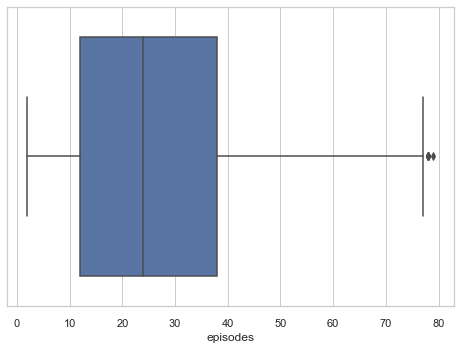

In [20]:
atr = 'episodes'
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=df_series[atr])

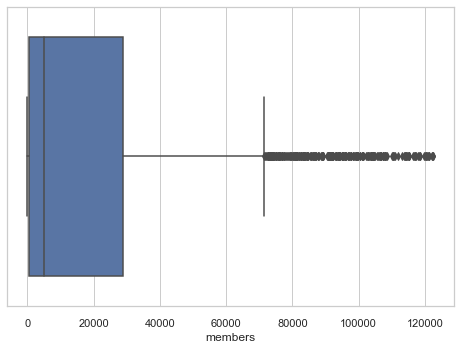

In [21]:
atr = 'members'
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=df_series[atr])

## Construccion del modelo de clustering

**Para construir un modelo adecuado, decidimos utilizar los generos mas populares y descartar las variables que no seran de demasiada utilidad. Ademas, normalizaremos los datos**

In [23]:
features = list(set(df_series.columns) - set(["anime_id","name","episodes"]))

rango_de_salida_de_las_variables_escaladas = (0,1)  #Tupla con el siguiente formato: (mínimo deseado, máximo deseado).
scaler = MinMaxScaler(feature_range=rango_de_salida_de_las_variables_escaladas)  #Instanciamos el objeto para escalar los datos. 

df_series_norm = deepcopy(df_series[features])  #Inicializamos este objeto con una copia profunda del las columnas de entrada de interés del dataframe.
df_series_norm[features] = scaler.fit_transform(df_series_norm) #Ajustamos y transformamos los datos.


In [25]:
# Agregar aqui correlacion entre las variables

In [ ]:
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
# HYPERPARÁMETROS DEL MODELO
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------

kmin              = 1           #Límite inferior para explorar el número de grupos.
kmax              = 10          #Límite superior para explorar el número de grupos.
init              ='k-means++'  #Se define el método de inicialización. Otra opción válida es 'random'.
n_init            = 10          #Número de inicializaciones aleatorias. Al final scikit learn escoge aquel con la menor inercia 
                                #(i.e.: suma de cuadrados de distancias de cada punto a su centroide respectivo dentro de cada grupo, para todos los puntos). 
                                #https://scikit-learn.org/stable/modules/clustering.html
max_iter          = 300         #Número MÁXIMO de iteraciones para una sola ejecución.
random_seed       = 42          #Semilla aleatoria. Permite obtener los mismos resultados en cada ejecución.


In [ ]:
df_x_norm = df_series_norm
# Vamos a dividir los datos en un conjunto de entrenamiento y un conjunto de pruebas.
mezclar_los_datos       = True #Vamos a mezclar de forma aleatoria los datos antes de particionarlos. 
valor_semilla_aleatoria = 42   #Esto es útil si se quiere garantizar la repetibilidad 
                               #de la partición de datos en ejecuciones sucesivas de su notebook o script.
particion_para_pruebas = 0.2

#Hacemos la partición para obtener el conjunto de pruebas y el "resto" (i.e.: entrenamiento y desarrollo).
df_x_train, df_x_test = train_test_split(df_x_norm,                                         
                                        test_size=particion_para_pruebas, 
                                        random_state=valor_semilla_aleatoria, 
                                        shuffle=mezclar_los_datos)

In [ ]:
#Revisemos los resultados del método de la silueta para algunos valores
#"tentativos" para k:
silhouette_score_list        = []

for k in [2, 3, 4,5,6,7,8,9,10]:
    model3 = KMeans(n_clusters=k,         #Se define el número de grupos.
                  init=init,            #Se define el método de inicialización. Otra opción es 'random'
                  n_init=n_init,        #Número de inicializaciones aleatorias. Al final se escoge aquel con la menor inercia: sum( (x_i-centroide(x_i))^2 ) 
                  max_iter=max_iter,    #Número MÁXIMO de iteraciones para una sola ejecución.
                  random_state=random_seed)
    model3.fit(df_x_train)
    sc = silhouette_score(df_x_train.values, model3.labels_)
    silhouette_score_list.append(sc)
    print(
        "For k clusters =",
        k,
        "The average silhouette_score is :",
        sc,
    )
    plt.figure(figsize=(10,3))  #Tamaño de la figura (ancho, alto).
    visualizer5 = SilhouetteVisualizer(estimator=model3, colors='yellowbrick')
    visualizer5.fit(df_x_train)
    visualizer5.show() 

In [ ]:
model2 = KMeans(init=init,              #Se define el método de inicialización. 
               n_init=n_init,           #Número de inicializaciones aleatorias. Al final se escoge aquel con la menor inercia: sum( (x_i-centroide(x_i))^2 ). 
               max_iter=max_iter,       #Número MÁXIMO de iteraciones para una sola ejecución.
               random_state=random_seed)

for metric in ["distortion", "silhouette", "calinski_harabasz"]:  #Itere sobre las métricas que soporta KElbowVisualizer.
  
  #Este condicional permite adaptar el flujo pues dos de las métricas requieren al menos 2 grupos para que se puedan calcular.
  if metric=="silhouette" or metric=="calinski_harabasz":  
    kmin_ = max(2,kmin)
  else:
    kmin_ = kmin
  
  plt.figure(figsize=(10,5))   #Tamaño de la figura (ancho, alto).
  visualizer2 = KElbowVisualizer(estimator=model2, 
                                  k=(kmin_,kmax+1),     #Permite explorar valores de k entre [kmin_,kmax].
                                  metric=metric,        #Opciones:  "distortion", "silhouette", "calinski_harabasz"
                                  timings=False,          
                                  locate_elbow=True)   #Si esta opción se activa, ubica el codo con una línea punteada.
  visualizer2.fit(df_x_train)   #Ajusta los datos al visualizador.
  visualizer2.show()

In [ ]:
#K-means
#-------------------------------------------------------------------------------
k = 3  #Número de grupos que se escogió después del análisis previo.

#Ahora se instancia el objeto para utilizar el agrupamiento con k-means.
#Para ver todas los opciones del constructor, consulte: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
#Nota: el algoritmo de k-means disponible en scikit-learn funciona únicamente con la distancia euclidiana.
#Si requiere aplicar k-means con otras métricas de distancia, puede consultar la librería PyClustering: https://github.com/annoviko/pyclustering
kmeans = KMeans(n_clusters   = k,            #Se define el número de grupos.
                init         = init,         #Se define el método de inicialización. Otra opción es 'random'
                n_init       = n_init,       #Número de inicializaciones aleatorias. 
                max_iter     = max_iter,     #Número MÁXIMO de iteraciones para una sola ejecución.
                random_state = random_seed)

#Hagamos el ajuste (i.e.: encontremos los centroides).
kmeans.fit(df_x_train)

#Revisemos los centroides de cada grupo.
centroides = kmeans.cluster_centers_
print('Centroides:', centroides)